In [1]:
!sudo apt install -y libsndfile1
!pip install numba==0.48
!pip install git+https://github.com/fastaudio/fastaudio.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
  Cloning https://github.com/fastaudio/fastaudio.git to /tmp/pip-req-build-7_guq_wb
  Running command git clone -q https://github.com/fastaudio/fastaudio.git /tmp/pip-req-build-7_guq_wb
     |████████████████████████████████| 194kB 13.7MB/s 
     |████████████████████████████████| 7.6MB 15.1MB/s 
     |████████████████████████████████| 184kB 45.6MB/s 
     |████████████████████████████████| 788kB 46.5MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
     |████████████████████████████████| 368kB 50.4MB/s 
  Created wheel for fastaudio: filename=fastaudio-0.1.4.post0.dev2+g8631a3f-py2.py3-none-any.whl size=18329 sha256=af9d59d24202ab3c6323922032b20f6a06e33468099e02580b9ce07303ff5353
  Stored in direc

In [3]:
!pip install timm
!pip install efficientnet_pytorch

     |████████████████████████████████| 245kB 12.8MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16032 sha256=d5c53903c6c25248d48848e17c729eca8791ea6d53115f20a7fa56ca64074b49
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torchaudio
torchaudio.set_audio_backend("sox_io")


/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [3]:
import numpy as np
import pandas as pd
import os
import sys
sys.path.append("..")

import librosa as lr
import librosa.display

import soundfile as sf
import io

from pathlib import Path
from tqdm.notebook import tqdm

from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastai.torch_basics import *
from fastai.basics import *
from fastai.data.all import *
from fastai.callback.all import *
from fastai.vision.all import *

import fastai
fastai.__version__

'2.1.8'

In [5]:
from google.colab import drive
drive.mount('/content/drive')# You must grant COLAB access to your Google Drive

Mounted at /content/drive


In [17]:
DATA_ROOT = Path("/content/drive/MyDrive/Colab Notebooks/RainForestAudio/data")
AUDIO_ROOT = Path(DATA_ROOT/"train/")
TRAIN_AUDIO_ROOT = Path(DATA_ROOT/"samples_long")
#TRAIN_AUDIO_ROOT = Path("/content/samples_long")
#TRAIN_AUDIO_ROOT = Path("/content/samples_mixed")
TEST_AUDIO_ROOT = Path(DATA_ROOT/"test")
VAL_AUDIO_ROOT = Path(DATA_ROOT/"val")
df_train = pd.DataFrame([path.stem for path in Path(TRAIN_AUDIO_ROOT).glob("*.flac")], columns=["recording_id"])
train_folds = np.load(Path(DATA_ROOT/"folds.npy"), allow_pickle=True)
df_test = pd.DataFrame([path.stem for path in Path(TEST_AUDIO_ROOT).glob("*.flac")], columns=["recording_id"])
df = pd.read_csv(Path(DATA_ROOT/"train_tp.csv"))
print(df_train.shape, df_test.shape)
df

(1216, 1) (1992, 1)


,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70
...,...,...,...,...,...,...,...
1211,fe8d9ac40,13,1,53.4720,93.750,54.0960,843.75
1212,fea6b438a,4,1,43.5787,2531.250,45.7653,4031.25
1213,ff2eb9ce5,0,1,15.2267,5906.250,16.0213,8250.00
1214,ffb8d8391,5,1,14.3467,4781.250,16.6987,10406.20


# Define multi class model

In [18]:
def get_y_fn(x):
  y = str(x).split(".")[0].split('_')[-2]
  return y

cfg = AudioConfig.BasicMelSpectrogram(
        mel=True,
  #      to_db = False
        f_min=df["f_min"].min(),
        f_max=df["f_max"].max(),
        # n_fft=1024,
        n_mels=384,
        hop_length=500,
        n_fft = 892, 
        #hop_length=245, 
        #n_mels = 224,
      #  normalized=True
   )

FOLD = 0
val_index = train_folds[FOLD]
FOLD = str(FOLD)
val_index

array([   0,    1,    4,    9,   10,   12,   20,   24,   53,   58,   66,
        776,  777,  778,  779,  780,  781,  782,  783,  784,  785,  786,
        787,  788,  789,  790,  791,  792,  793,  794,  795,  796,  797,
        798,  799,  800,  802,  833,  834,  835,  836,  837,  838,  844,
        845,  849,  883,  884,  971,  972,  973,  974,  975,  976,  977,
        978,  979,  980,  981,  982,  983,  984,  985,  988,  989,  991,
        995, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009,
       1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020,
       1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031,
       1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042,
       1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053,
       1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064,
       1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075,
       1076, 1077, 1078, 1079, 1080, 1081, 1082, 10

In [19]:
train_folds[0].shape

(240,)

## define mixup

In [20]:
!git clone https://github.com/nestordemeure/ManifoldMixupV2.git

fatal: destination path 'ManifoldMixupV2' already exists and is not an empty directory.


In [21]:
%run /content/ManifoldMixupV2/manifold_mixup.py
OutputMixup()

OutputMixup

## Define db and dls

In [22]:

def random_power(images, power = 1.5, c= 0.7):
    images = images**(torch.rand(1, device="cuda:0")*power + c)
    #print(images.dtype)
    return images

def normalize_mel(melspec):
    #normalize
    m = melspec.min(2, keepdim=True)[0]
    melspec -= m
    s = melspec.max(2, keepdim=True)[0]
    #s = torch.maximum(s, torch.ones_like(s)*1e-7)
    melspec /= s
    #print(melspec)
    return melspec

class Normalize_channel_1(Transform):
  def __init__(self):
    split_idx = None
  def encodes(self, melspec: AudioSpectrogram) -> AudioSpectrogram:
    return normalize_mel(melspec)

class Normalize_channel_2(Transform):
  def __init__(self):
    split_idx = None
  def encodes(self, melspec: AudioSpectrogram) -> AudioSpectrogram:
    return normalize_mel(melspec)

class Normalize_channel_3(Transform):
  def __init__(self):
    split_idx = None
  def encodes(self, melspec: AudioSpectrogram) -> AudioSpectrogram:
    return normalize_mel(melspec)

class PowerSpec(Transform):
    """
    Transform для возведения спектрограммы в степень.
    """
    def __init__(self, power = 2, c = 0.7):
      self.power = power
      self.c = c
      split_idx = None
    def encodes(self, melspec: AudioSpectrogram) -> AudioSpectrogram:
      mel = random_power(melspec, self.power, self.c)
      #print(melspec, mel, mel.size())
      return mel

class LowerUpperFreq(Transform):
    """
    Transform для понижения верхних частот.
    """
    def __init__(self, cfg):
      self.cfg = cfg
      split_idx = None
    def encodes(self, images: AudioSpectrogram) -> AudioSpectrogram:
      if torch.rand(1)<0.5:
        images = images - images.min(dim =2, keepdim=True)[0]
        r = random.randint(self.cfg.n_mels//2,self.cfg.n_mels)
        x = random.random()/2
        #print(r, x, torch.zeros(self.cfg.n_mels-r)-x+1)
        pink_noise = torch.cat((1-torch.arange(r, device="cuda:0")*x/r,
                                               torch.ones(self.cfg.n_mels-r, device="cuda:0")-x)).T

        #pink_noise = np.array([np.concatenate((1-np.arange(r)*x/r,np.zeros(self.hp.n_mels-r)-x+1))]).T
        #print(images.size(), pink_noise.size(), pink_noise)   
        #print(pink_noise, images)
        images = images.movedim(3,2)       

        images = images*pink_noise
        #images = images/(images.max(dim =2, keepdim=True)[0]
        images = images.movedim(3,2)
        #print(images.shape, images)
      return images

class RowNoise(Transform):
    """
    Transform полосового шума.
    """
    def __init__(self, level_noise, cfg):
      self.cfg = cfg
      self.level_noise = level_noise
      split_idx = 0
    def encodes(self, images: AudioSpectrogram) -> AudioSpectrogram:
      if torch.rand(1)<0.9:
        a = int(torch.rand(1, device="cuda:0") * self.cfg.n_mels//2)
        b =  int(torch.min(torch.rand(1, device="cuda:0") * self.cfg.n_mels, a+20))
        images[a:b,:] = images[a:b,:] + (torch.rand((b-a,images.size()[-1]), device="cuda:0")+9.0) * 0.05 * images.mean() * self.level_noise  * (torch.rand(1, device="cuda:0") + 0.3)

        
      return images

In [23]:
class PinkNoise(Transform):
    """
    Transform для розового шума.
    """
    def __init__(self, level_noise, cfg):
      self.level_noise = level_noise
      self.cfg = cfg
      split_idx = 0
    def encodes(self, images: AudioSpectrogram) -> AudioSpectrogram:
      if torch.rand(1)<0.9:
        r = random.randint(1, self.cfg.n_mels)
         #print(r, x, torch.zeros(self.cfg.n_mels-r)-x+1)
        pink_noise = torch.cat((1-torch.arange(r, device="cuda:0")/r,
                                               torch.zeros(self.cfg.n_mels-r, device="cuda:0"))).T

        #pink_noise = np.array([np.concatenate((1-np.arange(r)*x/r,np.zeros(self.hp.n_mels-r)-x+1))]).T
        #print(images.size(), pink_noise.size(), pink_noise)   
       
        images = images + (torch.rand((self.cfg.n_mels,images.size()[-1]), device="cuda:0")+9.0) * 2  * images.mean() * self.level_noise * (torch.rand(1, device="cuda:0") + 0.3)
        #print(pink_noise, images)
        #print(images.shape, images)
      return images

class WhiteNoise(Transform):
    """
    Transform для розового шума.
    """
    def __init__(self, level_noise, cfg):
      self.level_noise = level_noise
      self.cfg = cfg
      split_idx = 0
    def encodes(self, images: AudioSpectrogram) -> AudioSpectrogram:
      if torch.rand(1)<0.9:
        images = images + (torch.rand((self.cfg.n_mels,images.size()[-1]), device="cuda:0")+9.0) * images.mean() * self.level_noise * (torch.rand(1, device="cuda:0") + 0.3)
        #print(images.shape, images)
      return images



In [55]:
class TAmplitudeToDB(Transform):
    r"""Turn a tensor from the power/amplitude scale to the decibel scale.

    This output depends on the maximum value in the input tensor, and so
    may return different values for an audio clip split into snippets vs. a
    a full clip.

    Args:
        stype (str, optional): scale of input tensor ('power' or 'magnitude'). The
            power being the elementwise square of the magnitude. (Default: ``'power'``)
        top_db (float, optional): minimum negative cut-off in decibels.  A reasonable number
            is 80. (Default: ``None``)
    """
    __constants__ = ['multiplier', 'amin', 'ref_value', 'db_multiplier']

    def __init__(self, stype: str = 'power', top_db: Optional[float] = None) -> None:
        super(TAmplitudeToDB, self).__init__()
        self.stype = stype
        if top_db is not None and top_db < 0:
            raise ValueError('top_db must be positive value')
        self.top_db = top_db
        self.multiplier = 10.0 if stype == 'power' else 20.0
        self.amin = 1e-10
        self.ref_value = 1.0
        self.db_multiplier = math.log10(max(self.amin, self.ref_value))

    def forward(self, x: Tensor) -> Tensor:
        r"""Numerically stable implementation from Librosa.

        https://librosa.org/doc/latest/generated/librosa.amplitude_to_db.html

        Args:
            x (Tensor): Input tensor before being converted to decibel scale.

        Returns:
            Tensor: Output tensor in decibel scale.
        """
        print(x, "fin")

        x_db = self.multiplier * torch.log10(torch.clamp(x, min=self.amin))
        x_db -= self.multiplier * self.db_multiplier

        if self.top_db is not None:
          x_db = x_db.clamp(min=x_db.max().item() - self.top_db)

        #return F.amplitude_to_DB(x, self.multiplier, self.amin, self.db_multiplier, self.top_db)
        return x_db

class Mono2Color(Transform):
    """
    Transform для создания цветной картинки.
    """
    def __init__(self):
      split_idx = None
    def encodes(self, images: AudioSpectrogram) -> AudioSpectrogram:
      delta = torchaudio.functional.compute_deltas(images)
      delta2 = torchaudio.functional.compute_deltas(delta)
      colored_image = torch.cat((images, delta, delta2), dim=1)
      #print(colored_image.shape)
      return colored_image

In [82]:
cfg = AudioConfig.BasicMelSpectrogram(
        mel=True,
  #      to_db = False
        f_min=df["f_min"].min(),
        f_max=df["f_max"].max(),
        # n_fft=1024,
        n_mels=300,
        hop_length=748,
       # n_fft = 892, 
        #hop_length=245, 
        #n_mels = 224,
      #  normalized=True
   )

item_tfms = [Resample(28000),
             ResizeSignal(8000, pad_mode=AudioPadType.Repeat), 
        #    AddNoise(noise_level=0.05, color=NoiseColor.Pink),
        #    AddNoise(noise_level=0.05, color=NoiseColor.White),
           ]
batch_tfms = [ AudioToSpec.from_cfg(cfg), 
       #       Normalize_channel(),
       #       PowerSpec(), # увеличение контрастности
       #       TAmplitudeToDB(),
              Normalize_channel_1(),
              WhiteNoise(0.025, cfg),
              PinkNoise(0.025, cfg),
       #       RowNoise(0.025, cfg),
              LowerUpperFreq(cfg),
              Normalize_channel_2(),
              PowerSpec(), # увеличение контрастности
              Normalize_channel_3(),
              SGRoll(),
              MaskFreq(num_masks=1, size=20), 
              MaskTime(num_masks=1, size=16), 
              Mono2Color()
         #     Normalize(ch_mean, ch_std, axes=(0, 1, 3)),
              ]

MaskFreq.split_idx = 0
MaskTime.split_idx = 0
SGRoll.split_idx = 0

auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_items=get_audio_files,
                 item_tfms = item_tfms,
                 splitter = IndexSplitter(val_index.tolist()), #report unnesesary transform to list
                 #splitter = RandomSplitter(),
                 get_y=get_y_fn,
                 batch_tfms = batch_tfms
                                  )
print(auds.summary(TRAIN_AUDIO_ROOT))
dls = auds.dataloaders(TRAIN_AUDIO_ROOT, bs=24, verbose=True, before_batch = batch_tfms, 
                       num_workers=2
                       #, shuffle=True
                      )


Setting-up type transforms pipelines
Found 1216 items
2 datasets of sizes 976,240
Setting up Pipeline: partial
Setting up Pipeline: get_y_fn -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: partial
    starting from
      /content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples_long/3a1293df5_2_285.flac
    applying partial gives
      AudioTensor of size 1x252000
  Pipeline: get_y_fn -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/drive/MyDrive/Colab Notebooks/RainForestAudio/data/samples_long/3a1293df5_2_285.flac
    applying get_y_fn gives
      2
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(12)

Final sample: (AudioTensor([[ 0.0035,  0.0067,  0.0025,  ..., -0.0125, -0.0156, -0.0124]]), TensorCategory(12))


Found 1216 items
2 datasets of sizes 976,240
Setting up Pipeline: partial
Setting up Pipeline: get_y_fn -> Categori

In [83]:
def _one_sample_positive_class_precisions(scores, truth):
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)

    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)

    retrieved_classes = np.argsort(scores)[::-1]

    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)

    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True

    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)

    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits

def lwlrap(scores, truth):
    #print(truth.shape, scores.shape)
    num_samples, num_classes = scores.shape
    scores = scores.cpu().numpy()
    gt = np.zeros((num_samples, num_classes))
    for n, i in enumerate(truth.cpu().numpy().astype(int)):
      gt[n, i] = 1
    assert gt.shape == scores.shape
    
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = _one_sample_positive_class_precisions(scores[sample_num, :], gt[sample_num, :])
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = precision_at_hits

    labels_per_class = np.sum(gt > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))

    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    #return per_class_lwlrap, weight_per_class
    return (per_class_lwlrap * weight_per_class).sum()


In [84]:
from efficientnet_pytorch import EfficientNet
from timm import create_model
# from https://colab.research.google.com/github/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/05_EfficientNet_and_Custom_Weights.ipynb#scrollTo=VXPjDVUlJgCU

In [103]:
def create_timm_body(arch:str, pretrained=True, cut=None):
  model = create_model(arch, pretrained=pretrained, in_chans=3)
  if cut is None:
    ll = list(enumerate(model.children()))
    cut = next(i for i,o in reversed(ll) if has_pool_type(o))
  if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
  elif callable(cut): return cut(model)
  else: raise NamedError("cut must be either integer or function")
body = create_timm_body('tf_efficientnet_b3', pretrained=True)

head = create_head(num_features_model(nn.Sequential(*body.children())) * (2), dls.c)
model = nn.Sequential(body, head)
apply_init(model[1], nn.init.kaiming_normal_)
len(model)

2

In [104]:
learn = Learner(dls, 
            model,
           # n_in=1, #<- Only audio specific modification here
        #    loss_func=LabelSmoothingCrossEntropyFlat(),
            cbs = OutputMixup(alpha=0.4),
            metrics=[accuracy, lwlrap],
            train_bn=False)
learn.to_fp16()
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

(None,
 ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '3', '4', '5', '6', '7', '8', '9'])

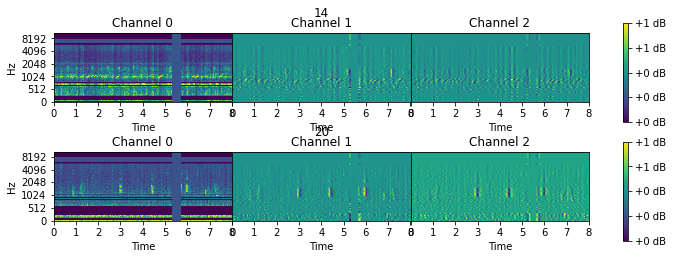

In [87]:
dls.show_batch(), dls.vocab

In [88]:
#learn.lr_find()

In [89]:
wdc wc  

SyntaxError: ignored

In [106]:
EXP_NAME = "b3_fold" + FOLD 
SUFFIX ="step1"
learn.freeze()
learn.fit(4, 1e-3)
learn.unfreeze()
learn.fit_one_cycle(25, 1e-3, wd=1e-2, div=10, pct_start=0.3,
                    cbs=[SaveModelCallback(fname = f'{EXP_NAME}_{SUFFIX}', with_opt=True)])

Output mixup: the loss function is now properly wrapped.


epoch,train_loss,valid_loss,accuracy,lwlrap,time
0,3.960907,4.990011,0.104167,0.251623,00:20
1,3.471908,3.464132,0.195833,0.360974,00:20
2,3.017960,2.425160,0.383333,0.524226,00:20
3,2.777859,2.415280,0.350000,0.518822,00:20


Output mixup: the loss function is now properly wrapped.


epoch,train_loss,valid_loss,accuracy,lwlrap,time
0,2.100588,2.020998,0.495833,0.628518,00:20
1,2.004263,1.851604,0.512500,0.650184,00:20
2,1.939418,1.840438,0.537500,0.678464,00:20
3,2.025464,2.396788,0.416667,0.572640,00:20
4,2.041086,2.353712,0.479167,0.615571,00:20
5,2.109132,2.556089,0.412500,0.565689,00:20
6,2.025777,2.141671,0.487500,0.626428,00:20
7,1.948902,2.305216,0.533333,0.656702,00:19
8,1.871967,2.176142,0.512500,0.644033,00:20
9,1.899542,1.937167,0.570833,0.687118,00:19


Better model found at epoch 0 with valid_loss value: 2.020998001098633.
Better model found at epoch 1 with valid_loss value: 1.8516039848327637.
Better model found at epoch 2 with valid_loss value: 1.8404383659362793.
Better model found at epoch 10 with valid_loss value: 1.5471036434173584.
Better model found at epoch 12 with valid_loss value: 1.4666475057601929.
Better model found at epoch 15 with valid_loss value: 1.3402936458587646.
Better model found at epoch 16 with valid_loss value: 1.1872421503067017.
Better model found at epoch 17 with valid_loss value: 1.1048136949539185.
Better model found at epoch 18 with valid_loss value: 1.0864806175231934.
Better model found at epoch 19 with valid_loss value: 1.0118855237960815.
Better model found at epoch 21 with valid_loss value: 0.9867125153541565.


In [107]:
SUFFIX ="step2"
#learn.load(EXP_NAME+"_step1")
learn.fit_one_cycle(25, 1e-3/5, wd=1e-2, div=10, pct_start=0.3,
                    cbs=[SaveModelCallback(fname = f'{EXP_NAME}_{SUFFIX}', with_opt=True)]
                    )

Output mixup: the loss function is now properly wrapped.


epoch,train_loss,valid_loss,accuracy,lwlrap,time
0,0.904762,1.045100,0.737500,0.831286,00:20
1,0.898088,1.129819,0.729167,0.819170,00:20
2,0.918935,1.157881,0.683333,0.797161,00:20
3,0.955292,1.045302,0.733333,0.831531,00:20
4,0.941380,1.155252,0.700000,0.808283,00:20
5,0.926806,1.141736,0.704167,0.811201,00:20
6,0.924112,1.076783,0.716667,0.818014,00:20
7,0.908735,1.250239,0.712500,0.802576,00:20
8,0.914053,1.273872,0.675000,0.778211,00:19
9,0.925110,1.264102,0.708333,0.800952,00:19


Better model found at epoch 0 with valid_loss value: 1.0451000928878784.


In [108]:
SUFFIX ="step3"
#learn.load(EXP_NAME+"_step2")
learn.to_fp16()
learn.fit_one_cycle(25, 1e-3/8, wd=1e-2, div=10, pct_start=0.3,
                    cbs=[SaveModelCallback(fname = f'{EXP_NAME}_{SUFFIX}', with_opt=True)]
                    )

Output mixup: the loss function is now properly wrapped.


epoch,train_loss,valid_loss,accuracy,lwlrap,time
0,0.908695,1.126729,0.737500,0.820338,00:18
1,0.929858,1.102368,0.700000,0.808496,00:21
2,0.951559,1.185193,0.712500,0.809780,00:21
3,0.905190,0.967409,0.750000,0.838089,00:21
4,0.918141,1.114080,0.729167,0.820309,00:21
5,0.933628,1.056187,0.720833,0.814926,00:21
6,0.929731,1.097367,0.695833,0.804211,00:21
7,0.922410,1.130270,0.704167,0.808139,00:21
8,0.906889,1.035962,0.741667,0.834596,00:22
9,0.925274,1.081106,0.737500,0.826961,00:21


Better model found at epoch 0 with valid_loss value: 1.1267293691635132.
Better model found at epoch 1 with valid_loss value: 1.1023682355880737.
Better model found at epoch 3 with valid_loss value: 0.9674087166786194.


In [ ]:
SUFFIX ="step3a"
learn.load(EXP_NAME+"_step2")
learn.to_fp16()
learn.fit_sgdr(5, 4, lr_max=1e-3/8, cycle_mult=2, 
               cbs=[SaveModelCallback(fname = f'{EXP_NAME}_{SUFFIX}', with_opt=True)], 
               reset_opt=False, wd=1e-2)

#combined_cos(0.25,0.5,1.,0.)

## confusion matrix

In [ ]:
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix()

# Predict all classes

In [ ]:
learn.load("b3_fold"+FOLD+"_step2", with_opt=False)
learn.remove_cbs(OutputMixup)
learn.cbs

In [ ]:
#!ln -s drive/MyDrive/Colab\ Notebooks/RainForestAudio/data/ol_samples.tar.gz ol_samples.tar.gz  
#!ln -s drive/MyDrive/Colab\ Notebooks/RainForestAudio/data/val  val


In [ ]:
TEST_SAMPLES_AUDIO_ROOT = Path("/content/samples")

#!ln -s drive/MyDrive/Colab\ Notebooks/RainForestAudio/data/val/ /content/val
VAL_AUDIO_ROOT = Path("/content/val")

test_ds = auds.new(VAL_AUDIO_ROOT)
test_dl = learn.dls.test_dl(get_audio_files(TEST_SAMPLES_AUDIO_ROOT))
#print(test_dl.summary(TEST_TARGET_AUDIO_ROOT))
#test_probas, *_ = learn.tta(dl=test_dl, n=2, use_max=True)
test_probas, *_ = learn.tta(dl=test_dl, n=6, use_max=False, beta=1/7)

In [ ]:
result=[]
for probas, fname in zip(test_probas, test_dl.items):
  print(fname)
  result.append([fname.stem.split("_")[0], fname.stem.split("_")[1], probas.numpy()])
res = pd.DataFrame(result, columns =["recording_id", "part_id", "probas"])
res["part_id"] = res["part_id"].astype(int)
res.to_csv("all_class_pred_"+FOLD+".csv", columns =["recording_id", "part_id", "probas"])

In [ ]:
subm = []
for n, row in res.sort_values(by="recording_id").groupby(by="recording_id"):
  a = np.stack(row["probas"].values)
  pred = np.concatenate([np.array(n).reshape(1),
                         np.array(dls.vocab[np.argmax(a.max(axis=0))]).reshape(1),
                         #np.where(a>0.7, a, 0).sum(axis=0)
                         a.max(axis=0)
                         ])
  subm.append(pred)
  #print(n)
  if n == "047a7c4bf":
    #print(row["probas"].max(axis=1))
    cls = np.stack(row["probas"].values).max(axis=0).argsort()
    #print(np.stack(row["probas"].values).argsort())
    #print(dls.vocab[cls[-1]], dls.vocab[cls[-2]], dls.vocab[cls[-3]])
#print(subm)
submission = pd.DataFrame(subm, columns=["recording_id"] + ["top_cat"] + ["s" + i for i in dls.vocab])
submission.head(10)

In [ ]:
submission.drop(["top_cat"], axis=1, inplace=True)
submission.to_csv("subm_26_fold_"+FOLD+"_2.csv", columns=["recording_id"] + ["s" + str(i) for i in range(24)], index=False)

In [ ]:
from sklearn.metrics import accuracy_score
gt=[]
pred=[]
for n, row in submission.iterrows():
  try:
    gr_tr = df[df["recording_id"] == row["recording_id"]]["species_id"].to_numpy()
    if gr_tr.shape[0] > 1:
      if int(row["top_cat"]) in gr_tr:
        gt.append(int(row["top_cat"]))
      else:
        gt.append(gr_tr[0])     
    else: 
      gt.append(gr_tr[0])
    pred.append(int(row["top_cat"]))
  except:
    pass
accuracy_score(gt,pred), len(gt)
#gt, pred

Усредненный сабмит

In [ ]:
subm = []
#subm.append(submission.sort_values(by="recording_id").to_numpy()[:,1:].astype(float))
for i in range(4):
  s = pd.read_csv("subm_20_fold_"+str(i)+".csv")
  subm.append(s.sort_values(by="recording_id").to_numpy()[:,1:])
subm = np.stack(subm)
subm.shape
fs = pd.DataFrame(np.concatenate([submission.sort_values(by="recording_id").to_numpy()[:,0].reshape(-1,1), subm.sum(axis=0)], axis=1),  columns=s.columns)
fs.head()

In [ ]:
fs.to_csv("subm_21_1.csv", index=False)

## Вспомогательное


In [ ]:
class MaskFreq_fixed(SpectrogramTransform):
    """Google SpecAugment frequency masking from https://arxiv.org/abs/1904.08779."""

    def __init__(self, num_masks=1, size=20, start=None, val=None):
        self.num_masks = num_masks
        self.size = size
        self.start = start
        self.val = val

    def encodes(self, sg: AudioSpectrogram) -> AudioSpectrogram:
        channel_mean = sg.contiguous().view(sg.size(0), -1).mean(-1)[:, None, None]
        mask_val = ifnone(self.val, channel_mean)
        if sg.ndim == 4:
          b, c, y, x = sg.shape
          # Position of the first mask
          start = ifnone(self.start, random.randint(0, y - self.size))
          for _ in range(self.num_masks):
              mask = torch.ones(self.size, x).cuda() * mask_val.cuda()
              mask = mask.view(b, c, self.size, x)
              #print("sg, mask:", sg.shape, mask.shape)
              if not 0 <= start <= y - self.size:
                  raise ValueError(
                      f"Start value '{start}' out of range for AudioSpectrogram of shape {sg.shape}"
                  )
              sg[:, :, start : start + self.size, :] = mask
              # Setting start position for next mask
              start = random.randint(0, y - self.size)
        else:
          c, y, x = sg.shape
          # Position of the first msk
          start = ifnone(self.start, random.randint(0, y - self.size))
          for _ in range(self.num_masks):
              mask = torch.ones(self.size, x) * mask_val
              if not 0 <= start <= y - self.size:
                  raise ValueError(
                      f"Start value '{start}' out of range for AudioSpectrogram of shape {sg.shape}"
                  )
              sg[:, start : start + self.size, :] = mask
              # Setting start position for next mask
              start = random.randint(0, y - self.size)
        return sg